<a href="https://colab.research.google.com/github/hubingqian2011/Big-Health-Data/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   NumRooms Alley   Price
0       NaN  Pave  127500
1       2.0   NaN  106000
2       4.0   NaN  178100
3       NaN   NaN  140000
   NumRooms Alley
0       3.0  Pave
1       2.0   NaN
2       4.0   NaN
3       3.0   NaN
   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1
h=0.10000, numerical limit=2.30000
h=0.01000, numerical limit=2.03000
h=0.00100, numerical limit=2.00300
h=0.00010, numerical limit=2.00030
h=0.00001, numerical limit=2.00003


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


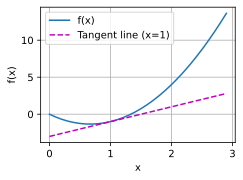

In [2]:
import torch

import os

os.makedirs(os.path.join('..', 'data'), exist_ok=True)
data_file = os.path.join('..', 'data', 'house_tiny.csv')
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # Column names
    f.write('NA,Pave,127500\n')  # Each row represents a data example
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

import pandas as pd

data = pd.read_csv(data_file)
print(data)

inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs = inputs.fillna(inputs.mean())
print(inputs)

inputs = pd.get_dummies(inputs, dummy_na=True)
print(inputs)

import torch

X, y = torch.tensor(inputs.values), torch.tensor(outputs.values)

import numpy as np
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt

def f(x):
    return 3 * x ** 2 - 4 * x

def numerical_lim(f, x, h):
    return (f(x + h) - f(x)) / h

h = 0.1
for i in range(5):
    print(f'h={h:.5f}, numerical limit={numerical_lim(f, 1, h):.5f}')
    h *= 0.1

def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

x = np.arange(0, 3, 0.1)
plot(x, [f(x), 2 * x - 3], 'x', 'f(x)', legend=['f(x)', 'Tangent line (x=1)'])

In [3]:
import torch
x = torch.arange(4.0)
print(x)

x.requires_grad_(True)  # Same as `x = torch.arange(4.0, requires_grad=True)`
print(x.grad)

y = 2 * torch.dot(x, x)
y.backward()
print(x.grad)

x.grad.zero_()
y = x.sum()
y.backward()
print(x.grad)

x.grad.zero_()
y = x * x
# y.backward(torch.ones(len(x))) equivalent to the below
y.sum().backward()
print(x.grad)

def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()
print(a.grad)

tensor([0., 1., 2., 3.])
None
tensor([ 0.,  4.,  8., 12.])
tensor([1., 1., 1., 1.])
tensor([0., 2., 4., 6.])
tensor(1638400.)


# Linear Neural Networks

features: tensor([ 0.0175, -0.0922]) 
label: tensor([4.5585])
epoch 1, loss 0.029558
epoch 2, loss 0.000101
epoch 3, loss 0.000046
error in estimating w: tensor([-0.0003, -0.0003], grad_fn=<SubBackward0>)
error in estimating b: tensor([-0.0005], grad_fn=<RsubBackward1>)


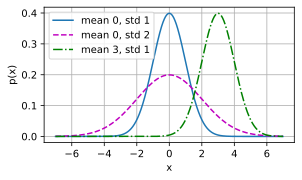

In [5]:
import math
import time
import numpy as np
import torch
import random

def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

# Use numpy again for visualization
x = np.arange(-7, 7, 0.01)

# Mean and standard deviation pairs
params = [(0, 1), (0, 2), (3, 1)]
plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# Generating the Dataset
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

# Reading the Dataset
def data_iter(batch_size, features, labels):
  num_examples = len(features) # how many examples
  indices = list(range(num_examples)) # define infices: 0,1,2,...,n

  random.shuffle(indices) # shuffle the dataset

  for i in range(0,num_examples, batch_size):
    batch_indices = torch.tensor( indices[ i : min(i+batch_size, num_examples)])

    yield features[batch_indices], labels[batch_indices]

# Initializing Model Parameters
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Defining the Model
def linreg(X, w, b):
    """The linear regression model."""
    return torch.matmul(X, w) + b

# Defining the Loss Function
def squared_loss(y_hat, y):
    """Squared loss."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

# Defining the Optimization Algorithm
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

# Training
lr = 0.03 # learning rate
num_epochs = 3
net = linreg
loss = squared_loss
batch_size = 10

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

In [7]:
# Concise Implementation of Linear Regression
import numpy as np
import torch
from torch.utils import data

# Generating the Dataset
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# Reading the Dataset
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# Defining the Model
net = torch.nn.Sequential(torch.nn.Linear(2, 1))

# Initializing Model Parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

# Defining the Loss Function
loss = torch.nn.MSELoss()

# Defining the Optimization Algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

# Training
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

epoch 1, loss 0.000191
epoch 2, loss 0.000099
epoch 3, loss 0.000099
error in estimating w: tensor([0.0004, 0.0006])
error in estimating b: tensor([-6.1989e-06])


60000
10000
torch.Size([1, 28, 28])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


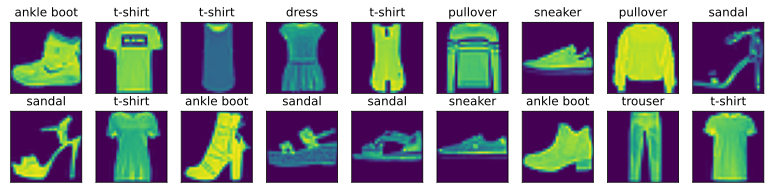

In [11]:
# Softmax Regression
# The Image Classification Dataset
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

use_svg_display()

# Reading the Dataset
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

print(len(mnist_train))
print(len(mnist_test))

print(mnist_train[0][0].shape)

def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

# Reading a Minibatch
batch_size = 256

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

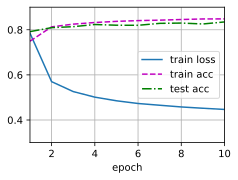

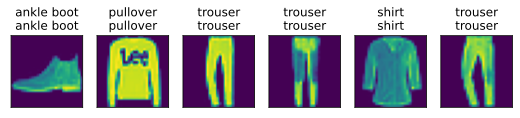

In [19]:
# Putting All Things Together
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))
    
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

# Implementation of Softmax Regression from Scratch
import torch
from IPython import display
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

# Initializing Model Parameters
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

# Defining the Softmax Operation
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]) # Example
X.sum(0, keepdim=True), X.sum(1, keepdim=True)       # Example

def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

X = torch.normal(0, 1, (2, 5))                           # Example
X_prob = softmax(X)                                      # Example
X_prob, X_prob.sum(1)                                    # Example

# Defining the Model
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# Defining the Loss Function
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

y = torch.tensor([0, 2])                                  # Example
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # Example
y_hat[[0, 1], y]                                          # Example  
cross_entropy(y_hat, y)                                   # Example

# Classification Accuracy
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)                               # Example

def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

def train_epoch_ch3(net, train_iter, loss, updater):
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

lr = 0.1

def updater(batch_size):
    return sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

def predict_ch3(net, test_iter, n=6):
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

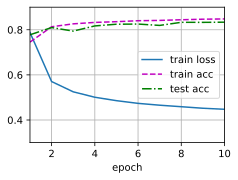

In [20]:
# Concise Implementation of Softmax Regression
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# Initializing Model Parameters
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss(reduction='none')

# Optimization Algorithm
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

# Training
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# Multilayer Perceptrons

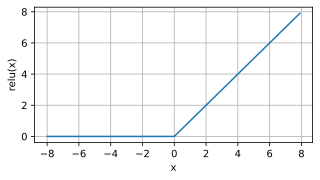

In [23]:
# Activation Functions
import torch
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

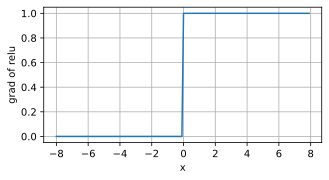

In [24]:
y.backward(torch.ones_like(x), retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

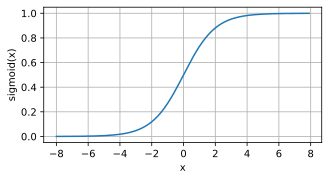

In [25]:
# Sigmoid Function
y = torch.sigmoid(x)
plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

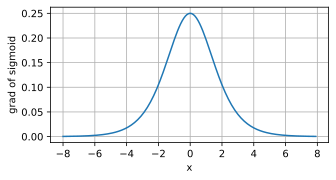

In [26]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

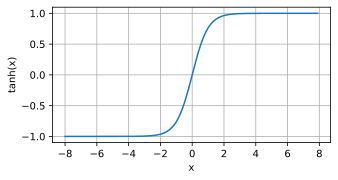

In [27]:
# Tanh Function
y = torch.tanh(x)
plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

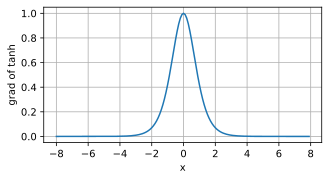

In [28]:
# Clear out previous gradients.
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

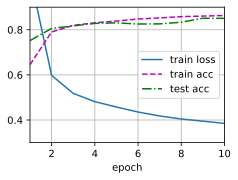

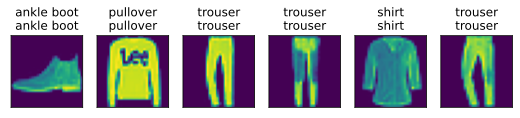

In [29]:
# Implementation of Multilayer Perceptrons from Scratch
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

# Initializing Model Parameters

num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

# Activation Function
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

# Model
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # Here '@' stands for matrix multiplication
    return (H@W2 + b2)

# Loss Function
loss = nn.CrossEntropyLoss(reduction='none')

# Training
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)
predict_ch3(net, test_iter)

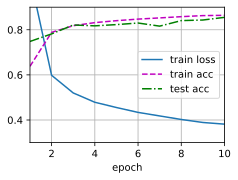

In [30]:
# Concise Implementation of Multilayer Perceptrons
import torch
from torch import nn

net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

weight: [[ 4.988485   1.1894468 -3.3743193  5.6207714]]


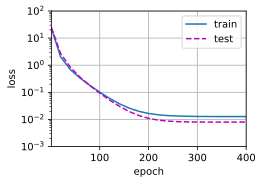

In [32]:
# Model Selection, Underfitting, and Overfitting
import math
import numpy as np
import torch
from torch import nn

max_degree = 20  # Maximum degree of the polynomial
n_train, n_test = 100, 100  # Training and test dataset sizes
true_w = np.zeros(max_degree)  # Allocate lots of empty space
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# Shape of `labels`: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # Switch off the bias since we already catered for it in the polynomial
    # features
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.646562 3.225946]]


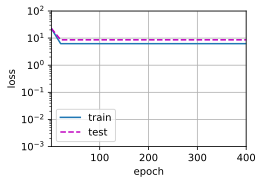

In [33]:
# Linear Function Fitting (Underfitting)
# Pick the first two dimensions, i.e., 1, x, from the polynomial features
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.965172    1.273595   -3.2550168   5.1232667  -0.27521968  1.348187
   0.1447984   0.4253563  -0.04371333 -0.13422303  0.05991725 -0.01626757
  -0.04432902  0.09814769 -0.18460181 -0.22235568 -0.18979703  0.17625962
  -0.04582666  0.11423312]]


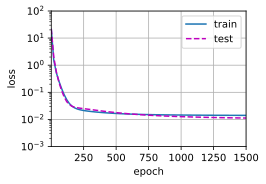

In [34]:
# Linear Function Fitting (Overfitting)

train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

L2 norm of w: 14.445027351379395


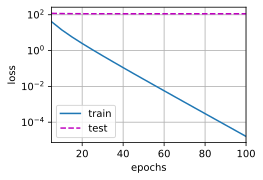

In [37]:
import torch
from torch import nn

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data  = synthetic_data(true_w, true_b, n_test)
test_iter  = load_array(test_data, batch_size, is_train=False)

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2    

def train(lambd):
    w, b = init_params()
    net, loss = lambda X: linreg(X, w, b), squared_loss
    num_epochs, lr = 100, 0.003
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

#Training without Regularization
train(lambd=0)

L2 norm of w: 0.3611164093017578


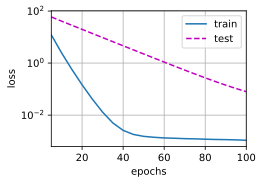

In [38]:
# Using Weight Decay
train(lambd=3)

L2 norm of w: 12.599414825439453


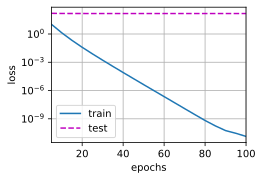

In [39]:
# Concise Implementation
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

train_concise(0)

L2 norm of w: 0.4989691972732544


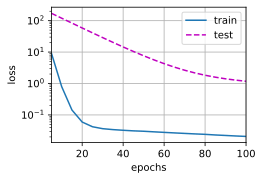

In [40]:
train_concise(3)

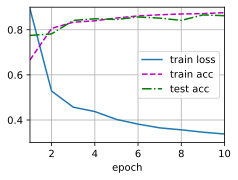

In [41]:
# Dropout

import torch
from torch import nn

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # In this case, all elements are dropped out
    if dropout == 1:
        return torch.zeros_like(X)
    # In this case, all elements are kept
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

# Defining Model Parameters
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # Use dropout only when training the model
        if self.training == True:
            # Add a dropout layer after the first fully connected layer
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # Add a dropout layer after the second fully connected layer
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

# Training and Testing
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

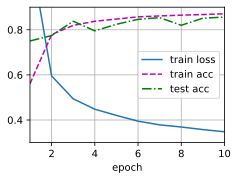

In [42]:
# Concise Implementation
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # Add a dropout layer after the first fully connected layer
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # Add a dropout layer after the second fully connected layer
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

a single matrix 
 tensor([[ 0.8132, -0.9060,  0.0323, -1.3371],
        [-1.7064,  0.0416,  0.3827, -0.9501],
        [-1.1084, -0.1507, -0.0719, -0.6589],
        [ 1.4360, -0.5936, -0.2489,  2.1938]])
after multiplying 100 matrices
 tensor([[ 7.9779e+22,  6.0814e+22,  1.4273e+22, -1.3020e+23],
        [-3.4662e+23, -2.6423e+23, -6.2014e+22,  5.6568e+23],
        [ 3.6222e+22,  2.7612e+22,  6.4805e+21, -5.9114e+22],
        [ 2.2011e+22,  1.6779e+22,  3.9381e+21, -3.5921e+22]])


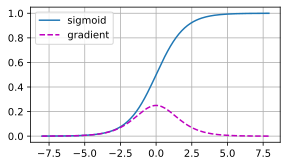

In [44]:
# Vanishing Gradients
import torch

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))

plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()],
         legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

M = torch.normal(0, 1, size=(4,4))
print('a single matrix \n',M)
for i in range(100):
    M = torch.mm(M,torch.normal(0, 1, size=(4, 4)))

print('after multiplying 100 matrices\n', M)

# Example：Predicting House Prices on Kaggle

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
(2919, 331)
fold 1, train log rmse 0.170626, valid log rmse 0.157237
fold 2, train log rmse 0.162237, valid log rmse 0.190143
fold 3, train log rmse 0.164030, valid log rmse 0.168845
fold 4, train log rmse 0.167854, valid log rmse 0.154478
fold 5, train log rmse 0.163582, valid log rmse 0.182699
5-fold validation: avg train log rmse: 0.165666, avg valid log rmse: 0.170680
train log rmse 0.162095


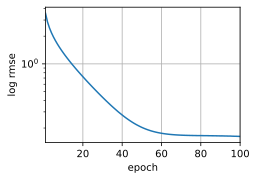

In [49]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """Download all files in the DATA_HUB."""
    for name in DATA_HUB:
        download(name)

import numpy as np
import pandas as pd
import torch
from torch import nn

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv','fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

# Data Preprocessing

# calculated from training data
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# After standardizing the data all means vanish, hence we can set missing values to 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# creates an indicator feature for it
all_features = pd.get_dummies(all_features, dummy_na=True)
print(all_features.shape)

n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

# Training
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

def log_rmse(net, features, labels):
    # To further stabilize the value when the logarithm is taken, set the
    # value less than 1 as 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = load_array((train_features, train_labels), batch_size)
    # The Adam optimization algorithm is used here
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

# K-Fold Cross-Validation
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# Model Selection
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-fold validation: avg train log rmse: {float(train_l):f}, '
      f'avg valid log rmse: {float(valid_l):f}')

def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # Apply the network to the test set
    preds = net(test_features).detach().numpy()
    # Reformat it to export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size) 

# Deep Learning Computation

In [52]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
print('net(X)')
print(net(X))

class MLP(nn.Module):
    # Declare a layer with model parameters. Here, we declare two fully
    # connected layers
    def __init__(self):
        # Call the constructor of the `MLP` parent class `Module` to perform
        # the necessary initialization. In this way, other function arguments
        # can also be specified during class instantiation, such as the model
        # parameters, `params` (to be described later)
        super().__init__()
        self.hidden = nn.Linear(20, 256)  # Hidden layer
        self.out = nn.Linear(256, 10)  # Output layer

    # Define the forward propagation of the model, that is, how to return the
    # required model output based on the input `X`
    def forward(self, X):
        # Note here we use the funtional version of ReLU defined in the
        # nn.functional module.
        return self.out(F.relu(self.hidden(X)))

net = MLP()
print('net(X)')
print(net(X))

class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # Here, `module` is an instance of a `Module` subclass. We save it
            # in the member variable `_modules` of the `Module` class, and its
            # type is OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict guarantees that members will be traversed in the order
        # they were added
        for block in self._modules.values():
            X = block(X)
        return X

net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
print('net(X)')
print(net(X))

class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Random weight parameters that will not compute gradients and
        # therefore keep constant during training
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # Use the created constant parameters, as well as the `relu` and `mm`
        # functions
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # Reuse the fully-connected layer. This is equivalent to sharing
        # parameters with two fully-connected layers
        X = self.linear(X)
        # Control flow
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()

net(X)
tensor([[-0.1859, -0.2516, -0.1120,  0.2166, -0.0405,  0.1526,  0.1172,  0.2875,
          0.2318,  0.0906],
        [-0.3007, -0.0791, -0.0828,  0.0513,  0.0168,  0.1723,  0.0076,  0.2702,
          0.2525,  0.0607]], grad_fn=<AddmmBackward0>)
net(X)
tensor([[-0.0935, -0.2022, -0.0326,  0.0814, -0.0392,  0.2080,  0.1681,  0.0811,
         -0.1110,  0.2837],
        [ 0.0808, -0.1096, -0.1723,  0.0726, -0.0601,  0.1815,  0.1942,  0.1224,
          0.0049,  0.2516]], grad_fn=<AddmmBackward0>)
net(X)
tensor([[ 0.0035, -0.0322, -0.2138,  0.2056,  0.3067,  0.2746,  0.2708, -0.1311,
          0.0482, -0.3434],
        [ 0.0014,  0.0101, -0.0694,  0.2888,  0.2220,  0.1128,  0.0870, -0.1146,
          0.0264, -0.1781]], grad_fn=<AddmmBackward0>)


In [53]:
# GPUs
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [58]:
import torch
from torch import nn

torch.device('cpu'), torch.device('cuda'), torch.device('cuda:1')
torch.cuda.device_count()
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

try_gpu(), try_gpu(10), try_all_gpus()

x = torch.tensor([1, 2, 3])
x.device

X = torch.ones(2, 3, device=try_gpu())
X

Y = torch.rand(2, 3, device=try_gpu(1))
Y

tensor([[0.6814, 0.1288, 0.3010],
        [0.3370, 0.8724, 0.3388]])

# Convolutional Neural Networks